In [2]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.optim as optim
import scipy.io as sio
import torch.nn as nn
import numpy as np
import shutil
import torch
import os

system = 'stochastic'
model_upper_dir = f'./models/{system}/'

d_of_x = 2 # number of variables
N_rec = 10 # number of recurrent steps
N_mem = 1 # memory length
d_input = N_mem * d_of_x # number of input nodes
d_output = d_of_x # number of output nodes
d_outputRNN = N_rec * d_output # total nubmer of output nodes (including recurrence)

n_hidden = 3 # number of hidden layers
n_nodes = 10 # number of nodes per hidden layer
n_epochs = 5_000 # number of epochs for training
learning_rate = 1e-4
N_seeds = 5 # number of seeds for ensemble learning
batch_size = 256 # batch size
verbose = True

# ODE data
matlab_data = sio.loadmat('../Data/data_fullsystem.mat')
inputs_train = matlab_data['input_data']
outputs_train = matlab_data['output_data']
inputs_test = matlab_data['input_test_data']
test_data = matlab_data['test_data']

inputs_train_torch  = torch.tensor(inputs_train, dtype=torch.float32)
outputs_train_torch = torch.tensor(outputs_train, dtype=torch.float32)
inputs_test_torch   = torch.tensor(inputs_test, dtype=torch.float32)
test_data_torch     = torch.tensor(test_data, dtype=torch.float32)

./models/stochastic/


In [43]:
class DeterministicSubMap(nn.Module):
    def __init__(self, d_of_x, N_mem = 1, N_rec = 40, n_hidden = 3, n_nodes = 10):
        super().__init__()

        self.recurrent_steps = N_rec
        input_dim = N_mem * d_of_x
        output_dim = d_of_x

        self.ReLU = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_dim, n_nodes))        # first layer (input dim -> n_nodes)
        for _ in range(n_hidden - 1):
            self.hidden_layers.append(nn.Linear(n_nodes, n_nodes))      # remaining layers
        self.last_linear = nn.Linear(n_nodes, output_dim)               # last layer

        self.slice_last_two = lambda x: x[:, -d_of_x:]
        self.slice_layer_Two = lambda x: x[:, d_of_x:]

    def forward_single(self, inputs):
        residual = inputs
        for layer in self.hidden_layers:
            residual = self.ReLU(layer(residual))
        residual = self.last_linear(residual)
        return residual

    def forward(self, inputs):
        x_last = self.slice_last_two(inputs)
        residual_output = self.forward_single(inputs)
        x_add_res = residual_output + x_last
        return x_add_res

    def forward_recurrence(self, inputs):
        # collect outputs at each recurrent step
        outputs = []  # z = []

        x = inputs
        x_minus_first_two = self.slice_layer_Two(x)
        x_last_two = self.slice_last_two(x)

        residual = self.forward_single(x)
        x_add_res = residual + x_last_two

        outputs.append(x_add_res)

        for _ in range(self.recurrent_steps - 1):
            x = torch.cat([x_minus_first_two, x_add_res], dim=1)
            x_minus_first_two = self.slice_layer_Two(x)
            x_last_two = self.slice_last_two(x)

            residual = self.forward_single(x)
            x_add_res = residual + x_last_two

            outputs.append(x_add_res)
        return torch.cat(outputs, dim=1)


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

inputs_train_torch = inputs_train_torch.to(device)
outputs_train_torch = outputs_train_torch.to(device)

Using mps device.


training model 1
Starting training
Epoch   10/7000, Loss: 0.009209 (Saved Best)
Epoch   20/7000, Loss: 0.001055 (Saved Best)
Epoch   30/7000, Loss: 0.000581 (Saved Best)
Epoch   40/7000, Loss: 0.000374 (Saved Best)
Epoch   50/7000, Loss: 0.000203 (Saved Best)
Epoch   60/7000, Loss: 0.000097 (Saved Best)
Epoch   70/7000, Loss: 0.000058 (Saved Best)
Epoch   80/7000, Loss: 0.000037 (Saved Best)
Epoch   90/7000, Loss: 0.000028 (Saved Best)
Epoch  100/7000, Loss: 0.000024 (Saved Best)
Epoch  110/7000, Loss: 0.000021 (Saved Best)
Epoch  120/7000, Loss: 0.000019 (Saved Best)
Epoch  130/7000, Loss: 0.000017 (Saved Best)
Epoch  140/7000, Loss: 0.000016 (Saved Best)
Epoch  150/7000, Loss: 0.000016 (Saved Best)
Epoch  160/7000, Loss: 0.000015 (Saved Best)
Epoch  170/7000, Loss: 0.000015 
Epoch  180/7000, Loss: 0.000014 (Saved Best)
Epoch  190/7000, Loss: 0.000014 (Saved Best)
Epoch  200/7000, Loss: 0.000014 (Saved Best)
Epoch  210/7000, Loss: 0.000014 
Epoch  220/7000, Loss: 0.000013 (Saved Best)

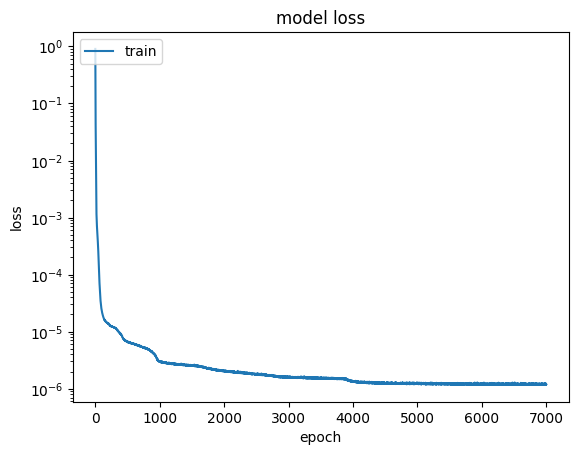


training model 2
Starting training
Epoch   10/7000, Loss: 0.001666 (Saved Best)
Epoch   20/7000, Loss: 0.000408 (Saved Best)
Epoch   30/7000, Loss: 0.000179 (Saved Best)
Epoch   40/7000, Loss: 0.000082 (Saved Best)
Epoch   50/7000, Loss: 0.000048 (Saved Best)
Epoch   60/7000, Loss: 0.000032 (Saved Best)
Epoch   70/7000, Loss: 0.000022 (Saved Best)
Epoch   80/7000, Loss: 0.000017 (Saved Best)
Epoch   90/7000, Loss: 0.000013 (Saved Best)
Epoch  100/7000, Loss: 0.000010 (Saved Best)
Epoch  110/7000, Loss: 0.000008 (Saved Best)
Epoch  120/7000, Loss: 0.000007 (Saved Best)
Epoch  130/7000, Loss: 0.000006 (Saved Best)
Epoch  140/7000, Loss: 0.000006 (Saved Best)
Epoch  150/7000, Loss: 0.000006 
Epoch  160/7000, Loss: 0.000005 (Saved Best)
Epoch  170/7000, Loss: 0.000005 
Epoch  180/7000, Loss: 0.000005 
Epoch  190/7000, Loss: 0.000004 (Saved Best)
Epoch  200/7000, Loss: 0.000004 (Saved Best)
Epoch  210/7000, Loss: 0.000004 
Epoch  220/7000, Loss: 0.000004 (Saved Best)
Epoch  230/7000, Loss:

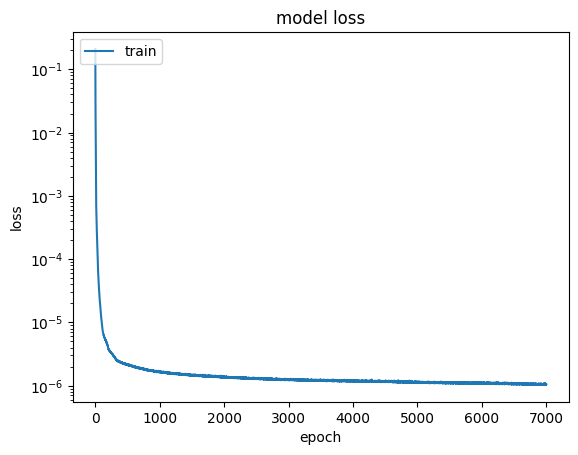


training model 3
Starting training
Epoch   10/7000, Loss: 0.003212 (Saved Best)
Epoch   20/7000, Loss: 0.000341 (Saved Best)
Epoch   30/7000, Loss: 0.000115 (Saved Best)
Epoch   40/7000, Loss: 0.000052 (Saved Best)
Epoch   50/7000, Loss: 0.000032 (Saved Best)
Epoch   60/7000, Loss: 0.000024 (Saved Best)
Epoch   70/7000, Loss: 0.000019 (Saved Best)
Epoch   80/7000, Loss: 0.000016 (Saved Best)
Epoch   90/7000, Loss: 0.000015 (Saved Best)
Epoch  100/7000, Loss: 0.000014 (Saved Best)
Epoch  110/7000, Loss: 0.000013 (Saved Best)
Epoch  120/7000, Loss: 0.000013 (Saved Best)
Epoch  130/7000, Loss: 0.000012 (Saved Best)
Epoch  140/7000, Loss: 0.000012 
Epoch  150/7000, Loss: 0.000011 (Saved Best)
Epoch  160/7000, Loss: 0.000010 (Saved Best)
Epoch  170/7000, Loss: 0.000010 (Saved Best)
Epoch  180/7000, Loss: 0.000009 (Saved Best)
Epoch  190/7000, Loss: 0.000009 
Epoch  200/7000, Loss: 0.000009 (Saved Best)
Epoch  210/7000, Loss: 0.000009 
Epoch  220/7000, Loss: 0.000008 (Saved Best)
Epoch  230

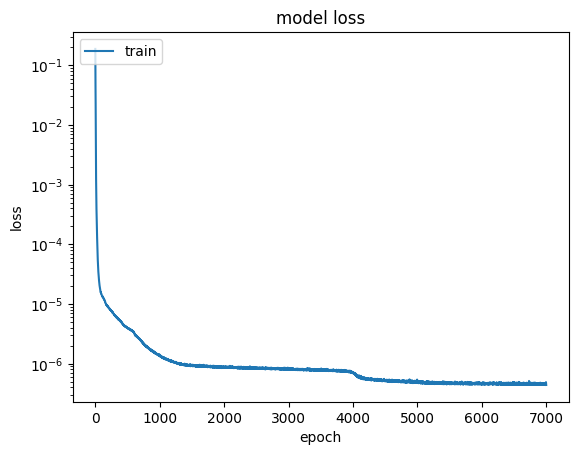


training model 4
Starting training
Epoch   10/7000, Loss: 0.008840 (Saved Best)
Epoch   20/7000, Loss: 0.001792 (Saved Best)
Epoch   30/7000, Loss: 0.000656 (Saved Best)
Epoch   40/7000, Loss: 0.000205 (Saved Best)
Epoch   50/7000, Loss: 0.000096 (Saved Best)
Epoch   60/7000, Loss: 0.000051 (Saved Best)
Epoch   70/7000, Loss: 0.000033 (Saved Best)
Epoch   80/7000, Loss: 0.000024 (Saved Best)
Epoch   90/7000, Loss: 0.000019 (Saved Best)
Epoch  100/7000, Loss: 0.000015 (Saved Best)
Epoch  110/7000, Loss: 0.000013 (Saved Best)
Epoch  120/7000, Loss: 0.000011 (Saved Best)
Epoch  130/7000, Loss: 0.000010 (Saved Best)
Epoch  140/7000, Loss: 0.000009 (Saved Best)
Epoch  150/7000, Loss: 0.000009 
Epoch  160/7000, Loss: 0.000009 (Saved Best)
Epoch  170/7000, Loss: 0.000009 
Epoch  180/7000, Loss: 0.000008 
Epoch  190/7000, Loss: 0.000008 
Epoch  200/7000, Loss: 0.000008 (Saved Best)
Epoch  210/7000, Loss: 0.000008 (Saved Best)
Epoch  220/7000, Loss: 0.000008 (Saved Best)
Epoch  230/7000, Loss:

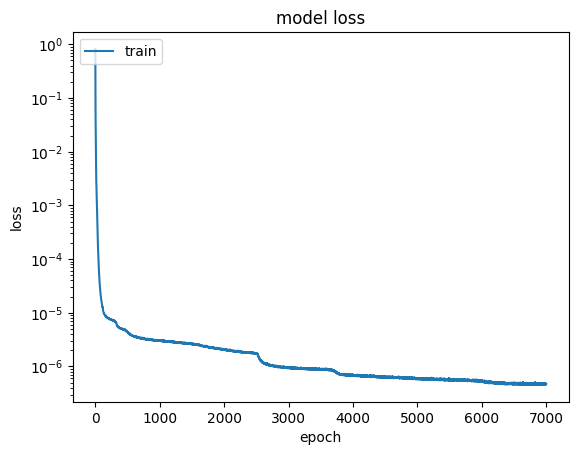


training model 5
Starting training
Epoch   10/7000, Loss: 0.008328 (Saved Best)
Epoch   20/7000, Loss: 0.001626 (Saved Best)
Epoch   30/7000, Loss: 0.000370 (Saved Best)
Epoch   40/7000, Loss: 0.000127 (Saved Best)
Epoch   50/7000, Loss: 0.000059 (Saved Best)
Epoch   60/7000, Loss: 0.000041 (Saved Best)
Epoch   70/7000, Loss: 0.000031 (Saved Best)
Epoch   80/7000, Loss: 0.000025 (Saved Best)
Epoch   90/7000, Loss: 0.000021 (Saved Best)
Epoch  100/7000, Loss: 0.000017 (Saved Best)
Epoch  110/7000, Loss: 0.000013 (Saved Best)
Epoch  120/7000, Loss: 0.000011 (Saved Best)
Epoch  130/7000, Loss: 0.000009 (Saved Best)
Epoch  140/7000, Loss: 0.000008 (Saved Best)
Epoch  150/7000, Loss: 0.000007 (Saved Best)
Epoch  160/7000, Loss: 0.000007 (Saved Best)
Epoch  170/7000, Loss: 0.000006 (Saved Best)
Epoch  180/7000, Loss: 0.000005 (Saved Best)
Epoch  190/7000, Loss: 0.000004 (Saved Best)
Epoch  200/7000, Loss: 0.000004 (Saved Best)
Epoch  210/7000, Loss: 0.000004 (Saved Best)
Epoch  220/7000, Lo

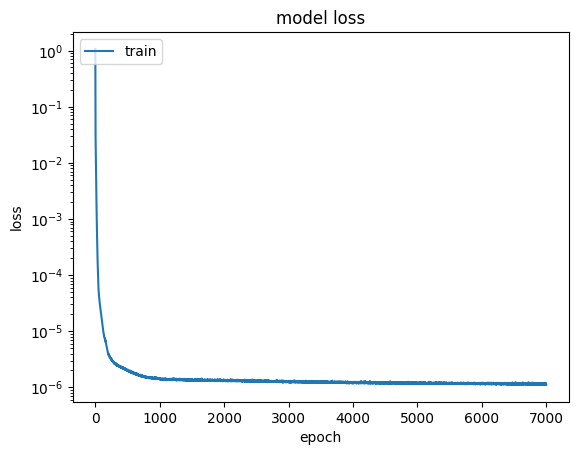


training model 6
Starting training
Epoch   10/7000, Loss: 0.002941 (Saved Best)
Epoch   20/7000, Loss: 0.000599 (Saved Best)
Epoch   30/7000, Loss: 0.000269 (Saved Best)
Epoch   40/7000, Loss: 0.000138 (Saved Best)
Epoch   50/7000, Loss: 0.000085 (Saved Best)
Epoch   60/7000, Loss: 0.000059 (Saved Best)
Epoch   70/7000, Loss: 0.000050 (Saved Best)
Epoch   80/7000, Loss: 0.000045 (Saved Best)
Epoch   90/7000, Loss: 0.000042 (Saved Best)
Epoch  100/7000, Loss: 0.000039 (Saved Best)
Epoch  110/7000, Loss: 0.000037 (Saved Best)
Epoch  120/7000, Loss: 0.000032 (Saved Best)
Epoch  130/7000, Loss: 0.000029 (Saved Best)
Epoch  140/7000, Loss: 0.000026 (Saved Best)
Epoch  150/7000, Loss: 0.000022 (Saved Best)
Epoch  160/7000, Loss: 0.000019 (Saved Best)
Epoch  170/7000, Loss: 0.000017 (Saved Best)
Epoch  180/7000, Loss: 0.000015 (Saved Best)
Epoch  190/7000, Loss: 0.000013 
Epoch  200/7000, Loss: 0.000012 (Saved Best)
Epoch  210/7000, Loss: 0.000011 
Epoch  220/7000, Loss: 0.000010 (Saved Best

KeyboardInterrupt: 

In [45]:
# 2
for seed in range(N_seeds):
    print(f"training model {seed + 1}")

    model_dir = model_upper_dir + f'/model_seed_{seed}/'
    model_weights_path = os.path.join(model_dir, 'best_weights.pth')
    plot_path = os.path.join(model_dir, 'loss_semilog.png')

    if os.path.exists(model_dir):
        shutil.rmtree(model_dir)
    os.makedirs(model_dir, exist_ok=True)

    train_dataset = TensorDataset(inputs_train_torch, outputs_train_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    torch.manual_seed(seed)

    model = DeterministicSubMap(d_of_x = d_of_x, N_mem = N_mem, N_rec = N_rec, n_hidden = n_hidden, n_nodes = n_nodes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    best_loss = float("inf")
    history_loss = []

    print("Starting training")
    for epoch in range(n_epochs):
        model.train()

        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            # reset gradients
            optimizer.zero_grad()

            outputs = model.forward_recurrence(inputs)
            loss = criterion(outputs, labels)

            # compute gradients
            loss.backward()

            # update weights
            optimizer.step()

            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(train_loader)
        history_loss.append(avg_epoch_loss)

        # Analogous to Keras ModelCheckpoint (monitor="loss", save_best_only=True)
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            # Save ONLY the weights (state_dict) of the best model
            torch.save(model.state_dict(), model_weights_path)
            saved_best = True
        else:
            saved_best = False

        if verbose:
            if (epoch + 1) % 10 == 0 or epoch == n_epochs - 1:
                print(f'Epoch {epoch + 1:4d}/{n_epochs}, Loss: {avg_epoch_loss:.6f} {"(Saved Best)" if saved_best else ""}')

    plt.semilogy(history_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig(model_dir + 'loss_semilog.png', bbox_inches='tight')
    plt.show()

    print()

In [46]:
inputs_test = inputs_test_torch

# --- ENSEMBLE PREDICTION PARAMETERS ---
N_test = 100          # Number of tests (trajectories)
N_step = 1000         # Number of prediction steps
N_seeds = 5          # Number of ensemble models/seeds

# --- PREDICTION INITIALIZATION ---
pred_np = np.zeros((N_test, d_of_x * (N_step + 1)), dtype=np.float32)
pred_np[:, :(d_of_x * N_mem)] = inputs_test
pred = torch.from_numpy(pred_np) # Convert to PyTorch tensor

# --- LOAD ENSEMBLE MODELS ---
ensemble_models = []
print("Loading ensemble models...")
for j in range(N_seeds):
    savedir = os.path.join(model_upper_dir, f'model_seed_{j}')
    model_path = os.path.join(savedir, f'best_weights.pth')

    model = DeterministicSubMap(d_of_x = d_of_x, N_mem = N_mem, N_rec = N_rec, n_hidden = n_hidden, n_nodes = n_nodes)

    # Load the state dictionary
    try:
        model.load_state_dict(torch.load(model_path))
        model.eval() # Set the model to evaluation mode (important for dropout/batchnorm)
        ensemble_models.append(model)
        print(f"Model seed {j} loaded successfully.")
    except FileNotFoundError:
        print(f"Warning: Model file not found for seed {j} at {model_path}. Skipping.")

if not ensemble_models:
    raise RuntimeError("No models were loaded. Check paths and model saving logic.")
print(f"Successfully loaded {len(ensemble_models)} models.")

# --- ENSEMBLE PREDICTION LOOP ---
print("\nStarting ensemble prediction...")

for i in range(N_step - N_mem + 1):
    print(f"Step {i+1} of {N_step}")

    # Calculate indices for the current step
    input_start_idx = i * d_of_x
    input_end_idx = input_start_idx + (N_mem * d_of_x)

    output_start_idx = input_end_idx
    output_end_idx = output_start_idx + d_of_x # Assuming N_rec=1
    current_input = pred[:, input_start_idx:input_end_idx]
    temp_step = torch.zeros(N_test, d_of_x, N_seeds)

    # --- Ensemble Forward Pass ---
    with torch.no_grad(): # Disable gradient calculations
        for l in range(N_seeds):
            model = ensemble_models[l]
            input_tensor = current_input.clone()
            model_output = model(input_tensor)
            temp_step[:, :, l] = model_output[:,:d_of_x]

    # --- Ensemble Averaging ---
    averaged_prediction = torch.mean(temp_step, dim=2)

    # --- Update the Prediction Tensor ---
    pred[:, output_start_idx:output_end_idx] = averaged_prediction

# --- SAVE RESULTS ---
final_pred_np = pred.numpy()

# Save as .csv
save_path_csv = os.path.join(model_upper_dir, 'pred.csv')
np.savetxt(save_path_csv, final_pred_np, delimiter=',')
print(f"\nFinal predictions saved to {save_path_csv}")

Loading ensemble models...
Model seed 0 loaded successfully.
Model seed 1 loaded successfully.
Model seed 2 loaded successfully.
Model seed 3 loaded successfully.
Model seed 4 loaded successfully.
Successfully loaded 5 models.

Starting ensemble prediction...
Step 1 of 1000
Step 2 of 1000
Step 3 of 1000
Step 4 of 1000
Step 5 of 1000
Step 6 of 1000
Step 7 of 1000
Step 8 of 1000
Step 9 of 1000
Step 10 of 1000
Step 11 of 1000
Step 12 of 1000
Step 13 of 1000
Step 14 of 1000
Step 15 of 1000
Step 16 of 1000
Step 17 of 1000
Step 18 of 1000
Step 19 of 1000
Step 20 of 1000
Step 21 of 1000
Step 22 of 1000
Step 23 of 1000
Step 24 of 1000
Step 25 of 1000
Step 26 of 1000
Step 27 of 1000
Step 28 of 1000
Step 29 of 1000
Step 30 of 1000
Step 31 of 1000
Step 32 of 1000
Step 33 of 1000
Step 34 of 1000
Step 35 of 1000
Step 36 of 1000
Step 37 of 1000
Step 38 of 1000
Step 39 of 1000
Step 40 of 1000
Step 41 of 1000
Step 42 of 1000
Step 43 of 1000
Step 44 of 1000
Step 45 of 1000
Step 46 of 1000
Step 47 of 10

tensor([-3.1322, -3.1081, -3.0811, -3.0510, -3.0181])

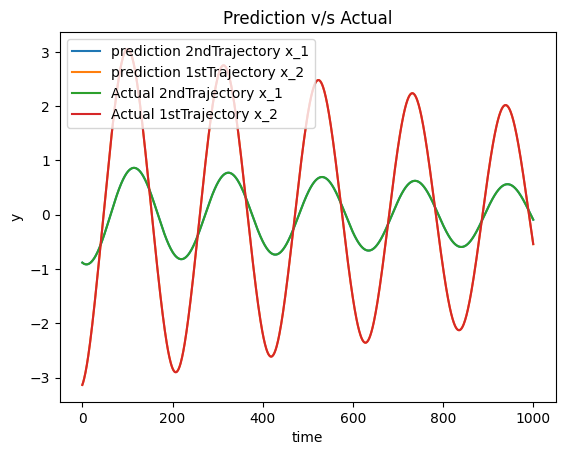

In [47]:
pred_reshaped = np.reshape(pred,(100,2,1001),order='F') # the order F ensures that the data is formated properly. Before this emthod, the data is stored as x_1(t1), x_2(t1), x_1(t2)...... Through this function we want to make the data as x_1(t1), x_1(t2)..., x_2(t1), x_2(t2).....
display(pred_reshaped[0,1,:5])                         # pred_reshaped[trajectories, variables(x1 or x2), time steps]
plt.plot(pred_reshaped[1,0,:], label = 'prediction 2ndTrajectory x_1')                          # plots the 1st trajectory, 1st variable(x1), all time steps
plt.plot(pred_reshaped[0,1,:], label = 'prediction 1stTrajectory x_2')                          # plots the 2nd trajectory, 2nd variable(x2), all time steps

test_data_permuted = np.transpose(test_data,(2,1,0))
plt.plot(test_data_permuted[1,0,:], label = 'Actual 2ndTrajectory x_1')
plt.plot(test_data_permuted[0,1,:], label = 'Actual 1stTrajectory x_2')

plt.legend(loc = 'upper left')
plt.title('Prediction v/s Actual')
plt.ylabel('y')
plt.xlabel('time')
plt.show()